# Prerequisites

In [1]:
import os
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import json
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
from IPython.display import display
from matplotlib.patches import Rectangle
from monai import losses
from monai.networks import nets
from skimage import measure
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

from BugNIST_metric import score
from dataset3d import BNSetMix, get_dloader_noise
from util3d import get_obj_score3d, get_saliency3d, show_volume

In [3]:
# Random seed
seed = 191510

data_dir = "/work3/s191510/data/BugNIST_DATA"
name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}
class_names = list(name_legend.keys())

model_types = {
    "r18": "ResNet 18",
}


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    model = nets.UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=len(name_legend) + 1,  # Bug classes and background
        channels=(32, 64, 128, 256),
        strides=(2, 2, 2),
        num_res_units=2,
    )

    model.to(device)
    return model

# Model

In [4]:
model_dir = "../models/bn-seg-checkpoints"
# run_dir = f"{model_dir}/run-20240606-213945"
run_dir = f"{model_dir}/run-20240607-112444"

with open(f"{run_dir}/config.json", "r") as f:
    config = json.load(f)
config

{'lr': 0.0001,
 'wd': 0.0,
 'batch_size': 16,
 'epochs': 200,
 'model_type': 'r18',
 'lr_step': 150,
 'perlin': True,
 'num_workers': 16,
 'save_every': 25,
 'wandb': True}

In [5]:
model = get_model("")
checkpoint = torch.load(f"{run_dir}/cpts/r18_e29_best.cpt")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
del checkpoint

In [68]:
dloader = get_dloader_noise("train", 1, "../data/BugNIST_DATA", seg=True)
perlin = True

if perlin:
    get_input = lambda volumes, masks, noise: volumes * masks + ~masks * noise
else:
    get_input = lambda volumes, masks, noise: volumes * masks

In [69]:
dloader_iter = iter(dloader)

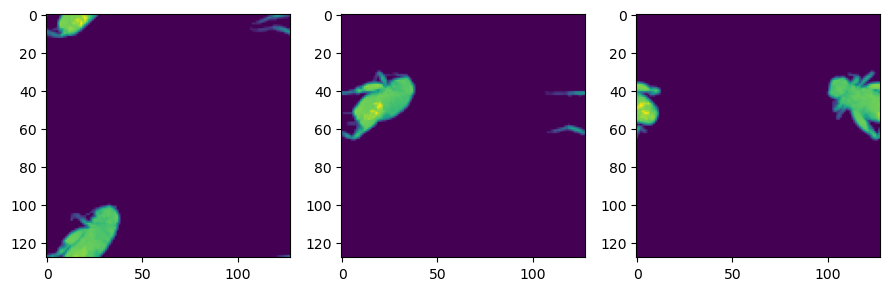

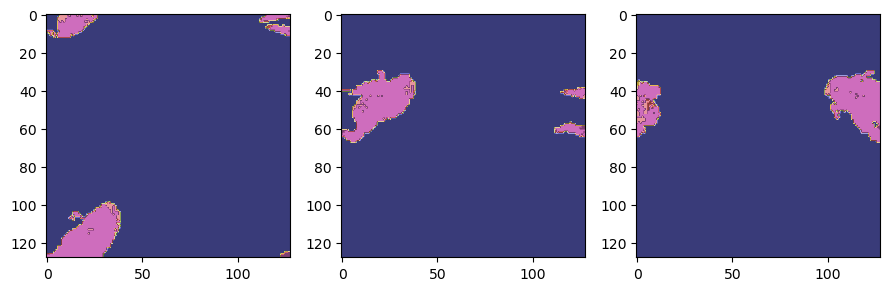

('wo', 'ac')

In [80]:
# volumes, labels, masks, noise = next(iter(dloader))
volumes, labels, masks, noise = next(dloader_iter)

with torch.no_grad():
    out = model(get_input(volumes, masks, noise))
pred = torch.softmax(out.detach(), dim=1)
scores, indices = pred.max(1)

show_volume(get_input(volumes, masks, noise * 0.5), size=3)
show_volume(indices, size=3, cmap="tab20b", vmax=len(class_names)+1)
classes, counts = indices.unique(return_counts=True)
classes, counts = classes[1:], counts[1:]
class_names[classes[counts.argmax()]-1], class_names[labels]

In [9]:
pred[0].size()

torch.Size([13, 128, 128, 128])

# Mix volumes

In [10]:
mixset = BNSetMix("../data/BugNIST_DATA/validation")

In [11]:
def seg_to_bbox(out):
    """From the bugnist kaggle challenge notebook: https://www.kaggle.com/code/patmjen/u-net-baseline"""

    pred_sm = out.softmax(dim=1).cpu().detach().numpy()
    class_props = []
    for i in range(1, 13):
        props = measure.regionprops(measure.label(pred_sm[0, i] > 0.5))
        props = [p for p in props if p.area > 5**3]
        class_props.append(props)

    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    return {
        "boxes": boxes,
        "centers": centers,
        "labels": labels,
        "scores": scores,
        "pred": pred_sm,
    }

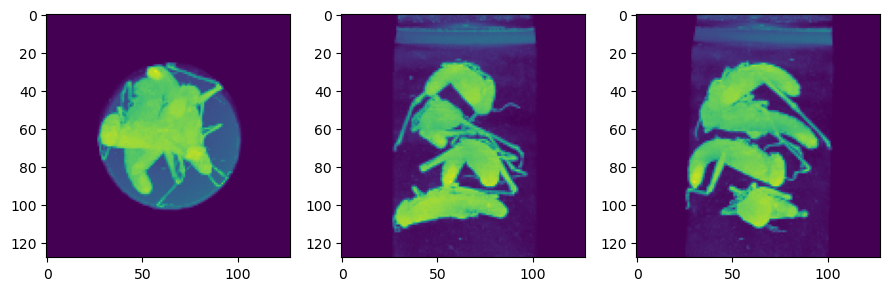

torch.Size([1, 128, 128, 128])

In [12]:
idx = 12
volume = mixset[idx][0]
volume = volume[:, :, 14:-14, 14:-14]
show_volume(volume, size=3)
volume.size()

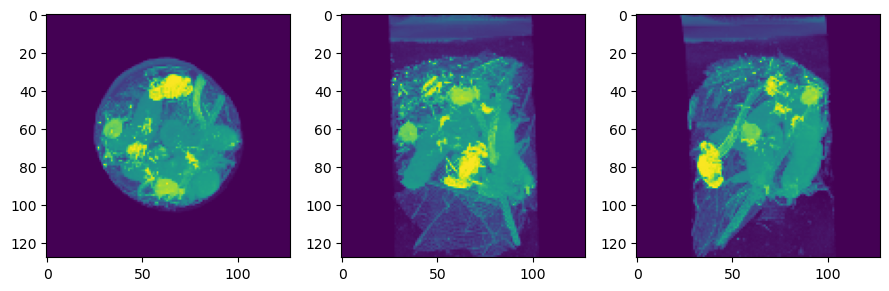

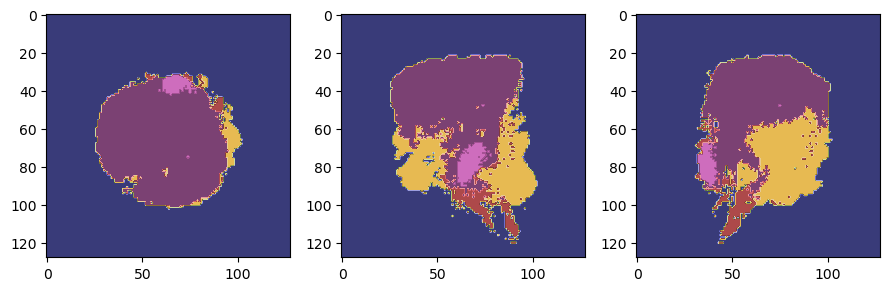

In [25]:
model.to('cpu')
with torch.no_grad():
    out = model(volume.unsqueeze(0))

pred = torch.softmax(out.detach(), dim=1)
scores, indices = pred.max(1)

pred = seg_to_bbox(out)
np.unique(pred["pred"][0].argmax(axis=0), return_counts=True)

show_volume(volume, size=3)
show_volume(indices, size=3, cmap="tab20b", vmax=len(class_names)+1)

In [14]:
pred = seg_to_bbox(out)

classes, counts = np.unique(pred["pred"][0].argmax(axis=0), return_counts=True)

classes, counts = classes[1:], counts[1:]
class_names[classes[counts.argmax()]-1]

'gh'

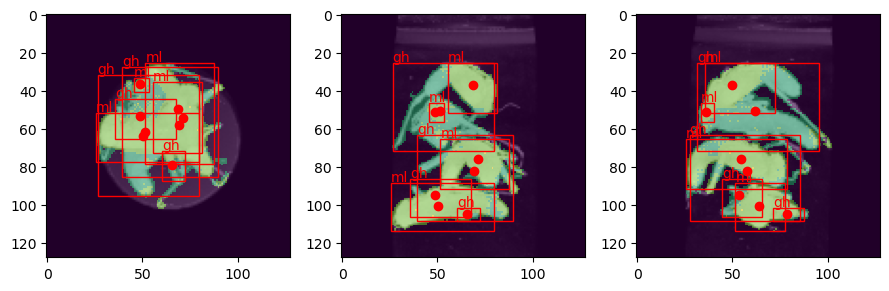

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
for a in range(3):
    ax = axs[a]

    # fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(volume[0].numpy().max(axis=a), cmap="gray")
    ax.imshow(
        pred["pred"][0].argmax(axis=0).max(axis=a), alpha=0.5, interpolation="none"
    )
    for box, center, label in zip(pred["boxes"], pred["centers"], pred["labels"]):
        if a == 0:
            center = (center[2] - 0.5, center[1] - 0.5)
            xy = (box[2] - 0.5, box[1] - 0.5)
            height = box[4] - box[1]
            width = box[5] - box[2]
        elif a == 1:
            center = (center[2] - 0.5, center[0] - 0.5)
            xy = (box[2] - 0.5, box[0] - 0.5)
            height = box[3] - box[0]
            width = box[5] - box[2]
        else:
            center = (center[1] - 0.5, center[0] - 0.5)
            xy = (box[1] - 0.5, box[0] - 0.5)
            height = box[3] - box[0]
            width = box[4] - box[1]
        ax.add_patch(Rectangle(xy, width, height, edgecolor="r", facecolor="none"))
        ax.plot(center[0], center[1], "ro")
        ax.text(xy[0], xy[1] - 1, class_names[label - 1], color="r")

In [16]:
validation = pd.read_csv("../data/BugNIST_DATA/validation/validation.csv", index_col=0)
validation.head()

,centerpoints
filename,
mix_02_006.tif,bl;48.61;39.14;96.19;bl;77.71;53.14;57.17;pp;5...
mix_02_011.tif,ml;77.86;46.26;57.79;sl;41.14;61.93;32.37;sl;5...
mix_03_001.tif,ml;54.20;34.58;81.43;ml;59.60;41.94;60.72;ml;4...
mix_03_003.tif,wo;44.37;27.71;85.18;wo;30.04;28.46;58.76;wo;4...
mix_03_004.tif,pp;74.65;44.18;52.53;pp;30.69;25.53;54.51;pp;1...


In [17]:
fname = os.path.basename(mixset.volumes[idx])
val_string = validation.loc[fname][0]
true_labels = val_string.split(";")[::4]
true_centers = np.array(
    [
        [float(x) for x in val_string.split(";")[1::4]],
        [float(x) for x in val_string.split(";")[2::4]],
        [float(x) for x in val_string.split(";")[3::4]],
    ]
).T

true_centers = true_centers[:, [2, 1, 0]]
true_centers += np.array([[0, 18, 18]])

print(true_labels)
print(true_centers)

['gh', 'gh', 'gh', 'gh']
[[101.13  64.4   50.78]
 [ 74.73  52.68  72.28]
 [ 54.58  56.96  51.16]
 [ 33.81  61.28  63.3 ]]


C:\Users\runes\AppData\Local\Temp\ipykernel_65032\4290442870.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_string = validation.loc[fname][0]


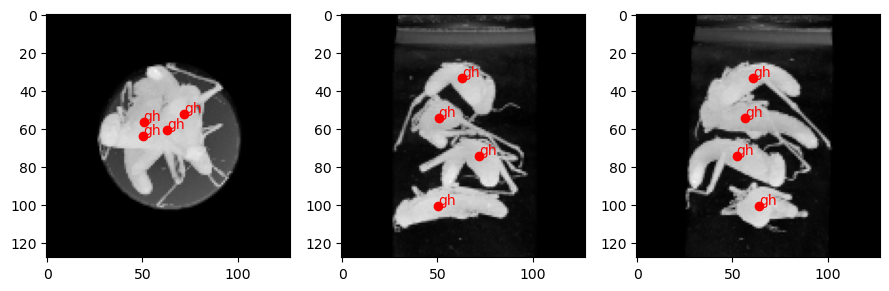

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
for a in range(3):
    ax = axs[a]

    ax.imshow(volume[0].numpy().max(axis=a), cmap="gray")
    for center, label in zip(true_centers, true_labels):
        if a == 0:
            center = (center[2] - 0.5, center[1] - 0.5)
        elif a == 1:
            center = (center[2] - 0.5, center[0] - 0.5)
        else:
            center = (center[1] - 0.5, center[0] - 0.5)
        ax.plot(center[0], center[1], "ro")
        ax.text(center[0], center[1] - 1, label, color="r")

In [19]:
def pack_prediction(centers, labels):
    centers = centers - np.array([[0, 18, 18]])
    strings = []
    for l, c in zip(labels, centers):
        strings.append(f"{l};{c[2]};{c[1]};{c[0]}")
    return ";".join(strings)

In [20]:
pred_text_labels = [class_names[l - 1].lower() for l in pred["labels"]]
pred_text_labels

['gh', 'gh', 'gh', 'gh', 'ml', 'ml', 'ml', 'ml']

In [21]:
pack_prediction(pred["centers"], pred_text_labels)

'gh;33.98640658951943;44.37060993481227;50.94173530749406;gh;51.447344500714195;40.29178028827425;82.88105440851838;gh;30.965576592082613;35.950086058519794;95.28915662650603;gh;48.047210300429185;61.39484978540773;105.32618025751073;ml;51.21642073401438;32.28433598183882;37.736284525160805;ml;30.955414012738856;18.7515923566879;51.7515923566879;ml;53.61907862607846;36.87628194693146;76.39003744098974;ml;32.9709922099221;46.41984419844198;100.95920459204592'

In [22]:
device = "cuda"
submission = {
    "filename": [],
    "centerpoints": [],
}

model.to(device)
for idx in tqdm(range(len(mixset))):
    volume = mixset[idx][0]
    volume = volume[:, :, 14:-14, 14:-14]
    with torch.no_grad():
        out = model(volume.unsqueeze(0).to(device))

    pred = seg_to_bbox(out)
    # pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred["labels"]]
    pred_text = pack_prediction(pred["centers"], pred_text_labels)
    submission["filename"].append(os.path.basename(mixset.volumes[idx]))
    submission["centerpoints"].append(pred_text)
submission = pd.DataFrame(submission)
submission.set_index("filename", inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:45<00:00,  1.71it/s]


In [23]:
display(submission.head())
display(validation.head())

,centerpoints
filename,
mix_02_006.tif,gh;33.563939738985724;40.316414119295786;53.50...
mix_02_011.tif,ac;35.62373247033441;60.47831715210356;36.0912...
mix_03_001.tif,gh;21.59239842726081;27.220183486238533;22.748...
mix_03_003.tif,gh;65.08062930186824;20.064896755162245;12.551...
mix_03_004.tif,ac;57.348684210526315;59.54276315789474;52.733...


,centerpoints
filename,
mix_02_006.tif,bl;48.61;39.14;96.19;bl;77.71;53.14;57.17;pp;5...
mix_02_011.tif,ml;77.86;46.26;57.79;sl;41.14;61.93;32.37;sl;5...
mix_03_001.tif,ml;54.20;34.58;81.43;ml;59.60;41.94;60.72;ml;4...
mix_03_003.tif,wo;44.37;27.71;85.18;wo;30.04;28.46;58.76;wo;4...
mix_03_004.tif,pp;74.65;44.18;52.53;pp;30.69;25.53;54.51;pp;1...


In [24]:
f1_mean = score(validation.reset_index(), submission.reset_index())
print(f"F1 score: {f1_mean:.3f}")

F1 score: 0.114
